In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import plotly
import datetime

In [2]:
perez = pd.read_csv('merged_perez.csv', index_col=0)

C:\Users\joshu\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [40]:
perez = perez.reset_index()

In [4]:
perez.head()

,DATES,UPC_F01,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT#,DEPT NAME,STORE NAME,STORE STATE
0,2018-12-22,2,PHONE CARD,$2 DOLLAR PHONE CARD,22.0,41.14,912,PHONE CARDS,1,GROCERY DEPT,FPEREZ,NC
1,2018-12-22,3,PHONE CARD,$3 PHONE CARD,3.0,8.39,912,PHONE CARDS,1,GROCERY DEPT,FPEREZ,NC
2,2018-12-22,5,PHONE CARD,$5 PHONE CARD,20.0,93.20,912,PHONE CARDS,1,GROCERY DEPT,FPEREZ,NC
3,2018-12-22,6,PAGE COPY,1 PAGE COPY,3.0,1.50,110,NON FOOD GROCERY,1,GROCERY DEPT,FPEREZ,NC
4,2018-12-22,13,GAS,GAS CILINDER REFILL,8.0,159.92,110,NON FOOD GROCERY,1,GROCERY DEPT,FPEREZ,NC


In [170]:
perez.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361665 entries, 0 to 1361664
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1361665 non-null  int64  
 1   DATES              1361665 non-null  object 
 2   UPC_F01            1361665 non-null  object 
 3   BRAND              1358561 non-null  object 
 4   DESCRIPTION        1361539 non-null  object 
 5   TotalUnits_F64     1361665 non-null  float64
 6   Total_Dollars_F65  1361665 non-null  float64
 7   SUB DPT #          1361665 non-null  int64  
 8   SUB DPT            1361665 non-null  object 
 9   DEPT#              1361665 non-null  int64  
 10  DEPT NAME          1361665 non-null  object 
 11  STORE NAME         1361665 non-null  object 
 12  STORE STATE        1361665 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 135.1+ MB


In [81]:
perez.isnull().sum()

DATES                   0
UPC_F01                 0
BRAND                3104
DESCRIPTION           126
TotalUnits_F64          0
Total_Dollars_F65       0
SUB DPT #               0
SUB DPT                 0
DEPT#                   0
DEPT NAME               0
STORE NAME              0
STORE STATE             0
dtype: int64

In [7]:
perez.dropna(inplace=True)
perez.isnull().sum()

Unnamed: 0           0
DATES                0
UPC_F01              0
BRAND                0
DESCRIPTION          0
TotalUnits_F64       0
Total_Dollars_F65    0
SUB DPT #            0
SUB DPT              0
DEPT#                0
DEPT NAME            0
STORE NAME           0
STORE STATE          0
dtype: int64

In [6]:
#drop unneeded columnns
perez.drop(columns=['DEPT#', 'STORE STATE'], inplace=True)

In [15]:
perez.head()

,DATES,UPC_F01,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT NAME
0,2018-12-22,2,PHONE CARD,$2 DOLLAR PHONE CARD,22.0,41.14,912,PHONE CARDS,GROCERY DEPT
1,2018-12-22,3,PHONE CARD,$3 PHONE CARD,3.0,8.39,912,PHONE CARDS,GROCERY DEPT
2,2018-12-22,5,PHONE CARD,$5 PHONE CARD,20.0,93.20,912,PHONE CARDS,GROCERY DEPT
3,2018-12-22,6,PAGE COPY,1 PAGE COPY,3.0,1.50,110,NON FOOD GROCERY,GROCERY DEPT
4,2018-12-22,13,GAS,GAS CILINDER REFILL,8.0,159.92,110,NON FOOD GROCERY,GROCERY DEPT


In [4]:
#some products had multiple transactions on same day. need to merge
msc = perez[perez['DESCRIPTION'] == 'MASECA CORN FLOUR']
agg_funcs = {'TotalUnits_F64':'sum', 'Total_Dollars_F65':'sum', 'UPC_F01':'first', 'BRAND':'first' , 'DESCRIPTION':'first', 'SUB DPT #':'first', 'SUB DPT':'first', 'DEPT#': 'first', 'DEPT NAME':'first', 'STORE NAME':'first', 'STORE STATE': 'first'}
msc = msc.groupby(msc['DATES']).aggregate(agg_funcs).reindex(columns=msc.columns)
msc = msc.drop(columns=['DATES'])
msc.reset_index(inplace=True)

perez = perez[perez['DESCRIPTION'] != 'MASECA CORN FLOUR']

och = perez[perez['DESCRIPTION'] == 'OLANCHO CREMA HONDURENA']
agg_funcs = {'TotalUnits_F64':'sum', 'Total_Dollars_F65':'sum', 'UPC_F01':'first', 'BRAND':'first' , 'DESCRIPTION':'first', 'SUB DPT #':'first', 'SUB DPT':'first', 'DEPT#': 'first', 'DEPT NAME':'first', 'STORE NAME':'first', 'STORE STATE': 'first'}
och = msc.groupby(och['DATES']).aggregate(agg_funcs).reindex(columns=och.columns)
och = och.drop(columns=['DATES'])
och.reset_index(inplace=True)

perez = perez[perez['DESCRIPTION'] != 'OLANCHO CREMA HONDURENA']

perez = perez.append(msc)
perez = perez.append(och)

In [7]:
perez['DATES'] = pd.to_datetime(perez['DATES'])
perez['YEAR'] = perez['DATES'].dt.year
perez['MONTH'] = perez['DATES'].dt.month
perez['WEEK'] = perez['DATES'].dt.isocalendar().week

In [45]:
#drop 2018 since the lack of captured data. 2018 only has 27k rows while 2019/20 have >600k
perez = perez[perez.YEAR != 2018]

In [46]:
revenue_by_year = perez.groupby(['YEAR']).sum()['Total_Dollars_F65']
revenue_by_year

YEAR
2019    7.997597e+06
2020    1.910838e+07
2021    3.193775e+06
Name: Total_Dollars_F65, dtype: float64

Text(0.5, 1.0, 'Revenue collected per year')

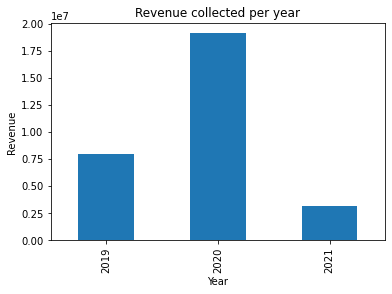

In [47]:
revenue_by_year.plot.bar()
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Revenue collected per year')

In [50]:
just2019 = perez[perez.YEAR == 2019]
just2020 = perez[perez.YEAR == 2020]
revenue_per_month = just2020.pivot_table(index='MONTH',values='Total_Dollars_F65',aggfunc='sum')
revenue_per_month

,Total_Dollars_F65
MONTH,
1,1328843.17
2,1584043.32
3,1864669.64
4,1461115.45
5,1984237.42
6,1621435.44
7,1497496.45
8,1757697.57
9,1398825.73


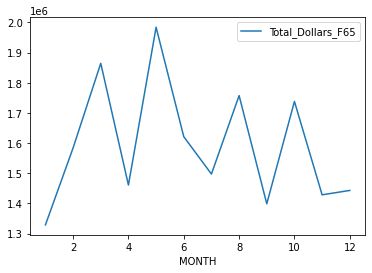

In [51]:
revenue_per_month.plot()

In [17]:
#most popular item in each department
perez.groupby('DEPT NAME')['DESCRIPTION'].apply(lambda x: x.value_counts().head(5))

DEPT NAME                                                    
DAIRY DEPT                     DAISY SOUR CREAM                  327
                               GOYA FROZEN YUCA                  323
                               OLANCHO CREMA HONDURENA           321
                               LA RICURA CREMA SALVADORENA       317
                               SUPREMO QUESO FRESCO              314
DISCOUNTS                      500 Points Get $5.00 OFF           24
                               APPCARD MISCELLANEOUS              15
                               1000 Points Get $10.00 OFF          6
                               2000 Points Get $20.00 OFF          5
                               1500 Points Get $15.00 OFF          2
FUSION LATINAMERICAN BAKERY D  FUSION MINI BOLILLO               108
                               PAN DE FERIA                      107
                               POUND CAKE PLAIN                  102
                               FUSION CUP

In [18]:
#least popular item in each department
perez.groupby('DEPT NAME')['DESCRIPTION'].apply(lambda x: x.value_counts().tail())

DEPT NAME                                                                
DAIRY DEPT                     SILK OATMEAL COOKIE CREAMER                     1
                               FRUTEL GUANABANA                                1
                               LA SABROSA ARROZ CON GUANDULES                  1
                               DAISY 2% TWIN PACK COTTAGE CHEESE               1
                               LEAN CUISINE FLATBREAD CHICKEN RANCH CLUB       1
DISCOUNTS                      2000 Points Get $20.00 OFF                      5
                               1500 Points Get $15.00 OFF                      2
                               COUPON  $20 DOLLARS OFF WITH 2000 POINTS        2
                               COUPON  $15 DOLLARS OFF WITH 1500 POINTS        1
                               COUPON  $5 DOLLARS OFF WITH 500 POINTS          1
FUSION LATINAMERICAN BAKERY D  PLAIN POUND CAKE                                2
                               FRES

In [114]:
#most number of products sold by department
perez.groupby('DEPT NAME').count()['TotalUnits_F64'].sort_values(ascending=False)

DEPT NAME
GROCERY DEPT                     1019891
DAIRY DEPT                        184812
MEAT DEPT                          77506
PRODUCE                            47704
MISCELLANEOUS DEPT                   720
FUSION LATINAMERICAN BAKERY D        685
DISCOUNTS                             56
Name: TotalUnits_F64, dtype: int64

In [115]:
perez.groupby('DEPT NAME').sum()['Total_Dollars_F65'].sort_values(ascending=False)

DEPT NAME
GROCERY DEPT                     2.856251e+07
PRODUCE                          1.184296e+07
MEAT DEPT                        1.179094e+07
DAIRY DEPT                       8.575292e+06
MISCELLANEOUS DEPT               1.247012e+05
FUSION LATINAMERICAN BAKERY D    4.830084e+04
DISCOUNTS                       -1.532006e+04
Name: Total_Dollars_F65, dtype: float64

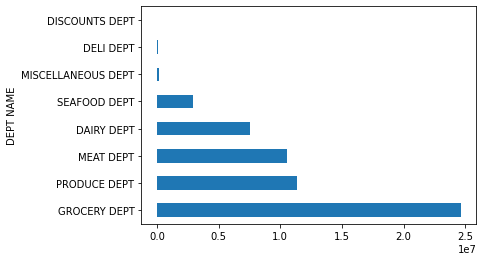

In [65]:
revenue_by_department = perez.groupby('DEPT NAME').sum()['Total_Dollars_F65'].sort_values(ascending=False)
revenue_by_department.plot.barh()

In [117]:
Returned_items = perez[perez.TotalUnits_F64<0].groupby(['DESCRIPTION', 'YEAR'])['TotalUnits_F64'].sum()
Returned_items = Returned_items.abs().sort_values(ascending=False)[0:10]
Returned_items

DESCRIPTION                                 YEAR
TITUS SARDINES IN OIL                       2020    20.0
VALLES ANDINOS ZARANDAJA                    2020     8.0
MORNING FRESH FARMS LOW FAT VANILLA YOGURT  2020     8.0
WATER 5 GALLON REFILL                       2020     7.0
CHINET CLASSIC WHITE 3 PLY TABLECOVER       2019     7.0
MUELLERS RIDGED JUMBO ELBOWS                2019     5.0
LA FE 10 DISCOS PARA  EMPANADAS             2020     4.0
DR. SNACK CASHEW / BRAZIL NUT               2020     4.0
DR. SNACK TRAIL MIX                         2019     4.0
MOUNTAIN DELIGHT YELLOW CORN                2020     4.0
Name: TotalUnits_F64, dtype: float64

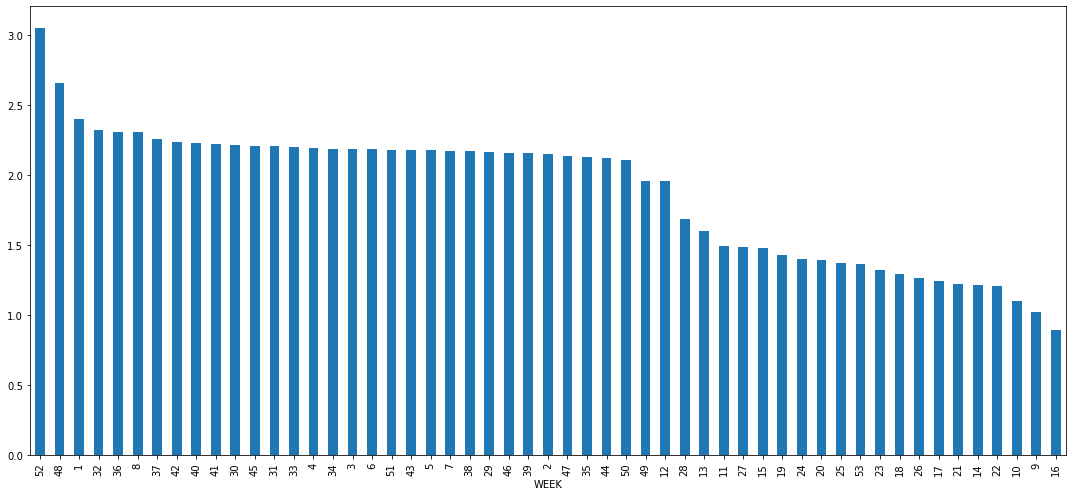

In [53]:
Sales_by_week = perez.groupby('WEEK')['Total_Dollars_F65'].sum()
percent_sales_by_week = (Sales_by_week / perez['Total_Dollars_F65'].sum() * 100).sort_values(ascending=False)
percent_sales_by_week.plot.bar(figsize=(15,7))
plt.tight_layout()

In [8]:
perez['Unit Price'] = abs(perez['Total_Dollars_F65']) / abs(perez['TotalUnits_F64'])

In [120]:
perez.head()

,DATES,UPC_F01,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT NAME,YEAR,MONTH,WEEK,Unit Price
27126,2019-01-05,2,PHONE CARD,$2 DOLLAR PHONE CARD,28.0,52.36,912,PHONE CARDS,GROCERY DEPT,2019,1,1,1.87
27127,2019-01-05,5,PHONE CARD,$5 PHONE CARD,20.0,93.20,912,PHONE CARDS,GROCERY DEPT,2019,1,1,4.66
27128,2019-01-05,13,GAS,GAS CILINDER REFILL,14.0,279.86,110,NON FOOD GROCERY,GROCERY DEPT,2019,1,1,19.99
27129,2019-01-05,132,AMERIMEX,AMERIMEX $2 REFILL,30.0,60.00,380,AMERIMEX,MISCELLANEOUS DEPT,2019,1,1,2.00
27130,2019-01-05,133,**NObrandFOUND**,AMERIMEX $3 REFILL,21.0,63.00,380,AMERIMEX,MISCELLANEOUS DEPT,2019,1,1,3.00


In [121]:
perez.replace([np.inf, -np.inf], np.nan, inplace=True)
perez.dropna(inplace=True)

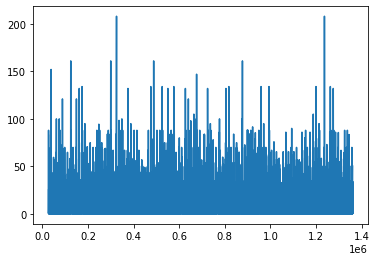

In [122]:
perez['Unit Price'].plot()

In [123]:
perez[perez['Unit Price'] == max(perez['Unit Price'])]

,DATES,UPC_F01,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT NAME,YEAR,MONTH,WEEK,Unit Price
325201,2019-07-13,80554110050,MI PUEBLO,MI PUEBLO TRIPLE QUEMADOR CON BASE,2.0,415.98,195,INTERNATIONAL NON FOOD GROCERY,GROCERY DEPT,2019,7,28,207.99
1236874,2020-12-12,80554110050,MI PUEBLO,MI PUEBLO TRIPLE QUEMADOR CON BASE,2.0,415.98,195,INTERNATIONAL NON FOOD GROCERY,GROCERY DEPT,2020,12,50,207.99


In [124]:
perez[perez['Unit Price'] == min(perez['Unit Price'])]

,DATES,UPC_F01,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT NAME,YEAR,MONTH,WEEK,Unit Price
103959,2019-02-16,2840020129,FRITO LAY,LAYS SWEET SOUTHERN HEAT BBQ,1.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,2,7,0.0
116106,2019-02-23,2840020128,FRITO LAY,LAYS DILL PIKLE,1.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,2,8,0.0
219088,2019-04-20,5070049767,HY TOP,HY TOP SALAD DRESING ITALIAN ZESTY,1.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,4,16,0.0
231947,2019-04-27,5070049680,HY TOP,HY TOP SALAD DRESSING FRENCH,1.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,4,17,0.0
241178,2019-06-01,2840064641,FRITO LAY,FRITO LAYS SOUR CREAM & ONION FAMILY SIZE,3.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,6,22,0.0
301660,2019-07-06,713,COUPON,BUY ONE GET ONE FREE SUNDOWN VITAMINS,1.000,0.0,140,HEALTH & BEAUTY CARE,GROCERY DEPT,2019,7,27,0.0
303925,2019-07-06,2840064191,FRITO LAY,FRITO LAY DORITOS TORTILLA CHIPS,1.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,7,27,0.0
316624,2019-07-13,2840004389,FRITO LAY,FRITO LAY FAMILY SIZE WAVY,2.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,7,28,0.0
329252,2019-07-20,2840064524,FRITO LAY,FRITO LAY BARBECUE FAMILY SIZE,1.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,7,29,0.0
379363,2019-08-17,2840058928,FRITO LAY,SABRITAS TURBOS FLAMAS,1.000,0.0,100,GROCERY DEPARTMENT,GROCERY DEPT,2019,8,33,0.0


In [125]:
perez[perez['Unit Price']>100]['DESCRIPTION'].unique().tolist()

['MI PUEBLO STAINLESS STEEL CAZO ACERO INOXIDABLE',
 'MI PUEBLO TAMALERA ALUMINIO 100 QT',
 'QUEMADOR CHEF ARK  BUR6800 SUPREME PROPANE GAS BURNER',
 'MI PUEBLO QUEMADOR ALTA PRESION',
 'MI PUEBLO QUEMADOR ALTA PRESION BASE CUADRADA',
 'MI PUEBLO TRIPLE QUEMADOR CON BASE',
 'MI PUEBLO QUEMADOR ALTA PRESION C/BASE 29"',
 'MI PUEBLO TAMALERA ALUMINIO 85 QT',
 'LA FORTUNA METATE PIEDRA NEGRA GR 15X12"']

In [9]:
most_pop = perez.groupby('DEPT NAME')['DESCRIPTION'].apply(lambda x: x.value_counts().head(10))
pop_dairy_products = most_pop['DAIRY DEPT']

In [10]:
top10_dairy_products_df = pop_dairy_products.reset_index().rename({'index':'DESCRIPTION', 'DESCRIPTION':'COUNT'}, axis = 'columns')

In [85]:
top10_dairy_products_df

,DESCRIPTION,COUNT
0,DAISY SOUR CREAM,327
1,GOYA FROZEN YUCA,323
2,OLANCHO CREMA HONDURENA,321
3,LA RICURA CREMA SALVADORENA,317
4,SUPREMO QUESO FRESCO,314
5,GOYA PLATANOS MADUROS,307
6,GOYA SOFRITO,296
7,TRADICIONES ANDINAS CHOCLO DESGRANADO,267
8,MORNING FRESH FARMS SHREDDED CHEDDAR CHEESE,260
9,EL SEMBRADOR FROZEN YUCA,254


In [11]:
top10_dairy_products = top10_dairy_products_df['DESCRIPTION'].tolist()

In [87]:
top10_dairy_products

['DAISY SOUR CREAM',
 'GOYA FROZEN YUCA',
 'OLANCHO CREMA HONDURENA',
 'LA RICURA CREMA SALVADORENA',
 'SUPREMO QUESO FRESCO',
 'GOYA PLATANOS MADUROS',
 'GOYA SOFRITO',
 'TRADICIONES ANDINAS CHOCLO DESGRANADO',
 'MORNING FRESH FARMS SHREDDED CHEDDAR CHEESE',
 'EL SEMBRADOR FROZEN YUCA']

In [12]:
#filter original df to capture only these products
perez_dairy = perez[perez['DESCRIPTION'].isin(top10_dairy_products)]

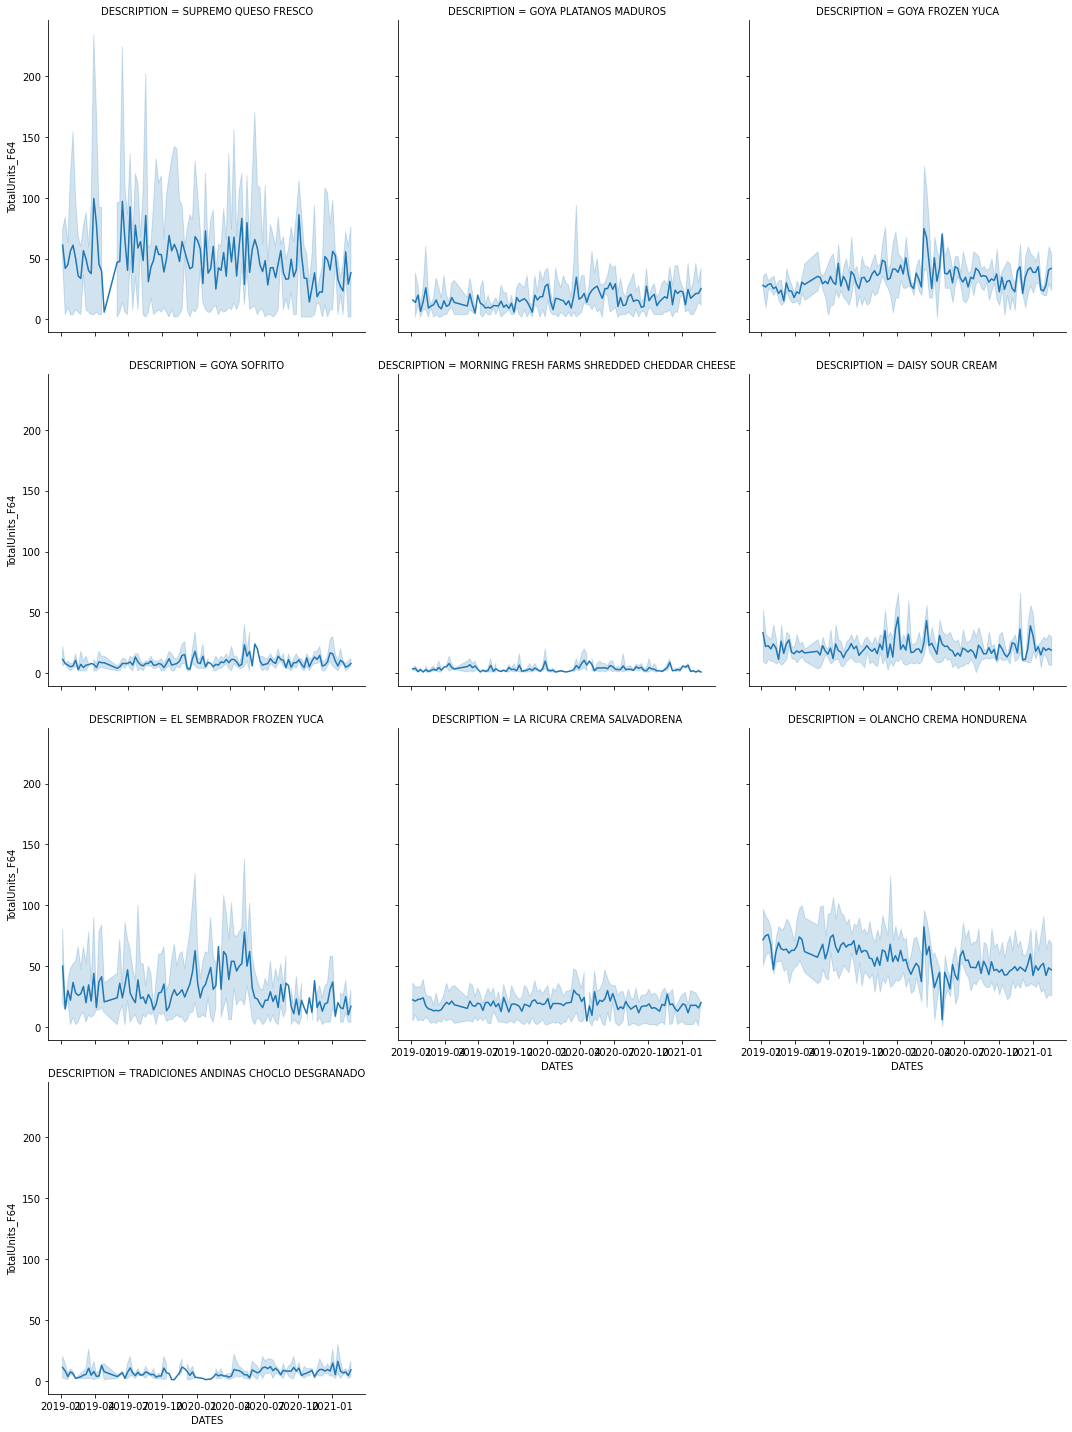

In [106]:
sns.relplot(x='DATES', y='TotalUnits_F64', col='DESCRIPTION', col_wrap=3, kind='line', data=perez_dairy)
plt.tight_layout()
plt.show()

In [13]:
Top10Rev = perez.groupby('DESCRIPTION',as_index=False)['Total_Dollars_F65','TotalUnits_F64'].sum().sort_values(by='Total_Dollars_F65',
                                                                                               ascending=False).head(10)

C:\Users\joshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [90]:
Top10Rev

,DESCRIPTION,Total_Dollars_F65,TotalUnits_F64
8464,DRY LOOSE RED BEANS,590818.50,3.178779e+05
11139,FRESH ROMA TOMATO,583376.48,4.238027e+05
11024,FRESH HASS AVOCADOS,569791.54,4.410170e+05
11199,FRESH SWEET PAPAYA,491454.26,3.954700e+05
11061,FRESH LIMES JUICY,453121.94,2.035182e+06
11260,FRESH YELLOW PLANTAIN,425000.39,7.265810e+05
34629,WIC GOOD START GENTLE PDW,391670.66,1.854400e+04
21508,MASECA CORN FLOUR,386458.83,1.536030e+05
2566,BEEF SKIR STEAK,311354.55,3.408675e+04
6360,COSTILLA GRUESA DE RES,306241.49,4.269657e+04


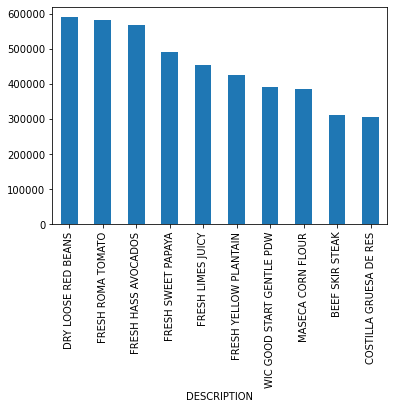

In [114]:
Top10Rev.plot(x="DESCRIPTION", y="Total_Dollars_F65", legend=False,kind='bar')


In [66]:
Top10SubDept = perez.groupby('SUB DPT',as_index=False)['Total_Dollars_F65','TotalUnits_F64'].sum().sort_values(by='Total_Dollars_F65',
                                                                                               ascending=False).head(10)

C:\Users\joshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


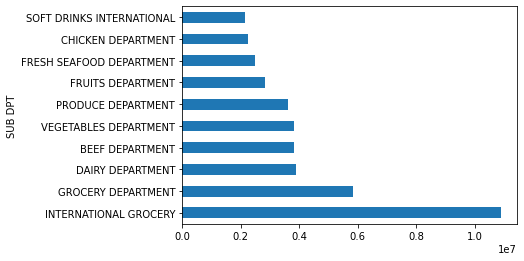

In [67]:
#top revenue by sub department
Top10SubDept.plot.barh(x="SUB DPT", y="Total_Dollars_F65", legend=False)

In [15]:
TopRev_Subdepts = ['INTERNATIONAL GROCERY', 'VEGETABLES DEPARTMENT', 'GROCERY DEPARTMENT']

top_subdept_df = perez[perez['SUB DPT'].isin(TopRev_Subdepts)]
top_subdept_df.head()

,DATES,UPC_F01,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT NAME,YEAR,MONTH,WEEK
27144,2019-01-05,2141,FRESH,FRESH YELLOW TUMERIC,5.94,23.73,320,VEGETABLES DEPARTMENT,PRODUCE,2019,1,1
27148,2019-01-05,2191,FRESH,FRESH LEMON GRASS (USA),3.00,8.97,320,VEGETABLES DEPARTMENT,PRODUCE,2019,1,1
27151,2019-01-05,3073,FRESH,FRESH BASIL/ALBAHACA,39.00,194.61,320,VEGETABLES DEPARTMENT,PRODUCE,2019,1,1
27152,2019-01-05,3082,FRESH,FRESH CROWN LOOSE BROCCOLI,217.38,485.58,320,VEGETABLES DEPARTMENT,PRODUCE,2019,1,1
27155,2019-01-05,3121,USA,FRESH ORANGE BELL PEPPER,17.54,78.73,320,VEGETABLES DEPARTMENT,PRODUCE,2019,1,1


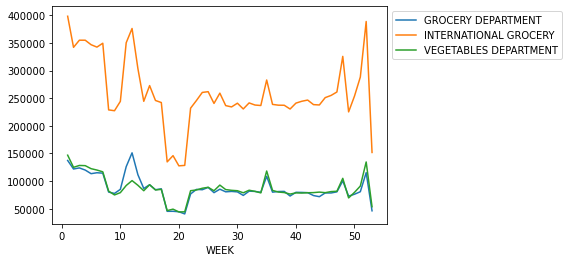

In [19]:
top_subdept_df.groupby(['SUB DPT', 'WEEK'])['Total_Dollars_F65'].sum().unstack('SUB DPT').plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

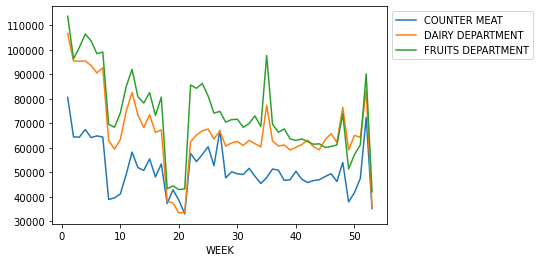

In [20]:
other_Subdepts = ['COUNTER MEAT', 'FRUITS DEPARTMENT', 'DAIRY DEPARTMENT']

other_subdept_df = perez[perez['SUB DPT'].isin(other_Subdepts)]

other_subdept_df.groupby(['SUB DPT', 'WEEK'])['Total_Dollars_F65'].sum().unstack('SUB DPT').plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [15]:
#this helps us understand why we see those big dips in weeks 18-21. The number of transactions is about half
top_subdept_df.groupby('WEEK').size().sort_values()

WEEK
21     5098
20     5111
18     5240
19     5249
53     5609
22    10102
49    10162
39    10238
26    10241
31    10296
28    10331
33    10383
36    10397
40    10398
43    10403
38    10433
30    10434
23    10452
8     10468
17    10473
34    10486
44    10499
29    10502
27    10548
37    10567
32    10577
9     10604
50    10614
42    10617
25    10618
24    10624
45    10627
46    10662
41    10684
16    10851
14    10859
47    10864
10    10981
15    11152
13    11406
11    11544
48    11902
12    12383
35    13497
5     15647
7     15721
2     15727
6     15745
4     15848
3     15893
1     16662
51    17015
52    18534
dtype: int64

In [21]:
top_subdept_df_2019 = top_subdept_df[top_subdept_df['YEAR'] == 2019]
top_subdept_df_2020 = top_subdept_df[top_subdept_df['YEAR'] == 2020]

In [22]:
top_subdept_df_2019.groupby('WEEK').size()

WEEK
1     5733
2     5444
3     5583
4     5592
5     5399
6     5326
7     5328
8     5252
9     5373
10    5691
11    5273
12    5378
13    5315
14    5496
15    5608
16    5873
17    5257
22    5251
23    5469
24    5585
25    5470
26    5334
27    5528
28    5391
29    5493
30    5360
31    5347
32    5466
33    5345
34    5485
35    5290
36    5509
37    5427
38    5385
39    5180
40    5278
41    5464
42    5385
43    5280
44    5306
45    5405
46    5423
47    5451
48    5942
49    5030
50    5311
51    5567
52    6137
dtype: int64

<h3> Why are weeks 18-21 missing in 2019?? <h3>

In [23]:
top_subdept_df_2020.groupby('WEEK').size()

WEEK
1     5613
2     5116
3     5114
4     5084
5     5002
6     5148
7     5080
8     5216
9     5231
10    5290
11    6271
12    7005
13    6091
14    5363
15    5544
16    4978
17    5216
18    5240
19    5249
20    5111
21    5098
22    4851
23    4983
24    5039
25    5148
26    4907
27    5020
28    4940
29    5009
30    5074
31    4949
32    5111
33    5038
34    5001
35    8207
36    4888
37    5140
38    5048
39    5058
40    5120
41    5220
42    5232
43    5123
44    5193
45    5222
46    5239
47    5413
48    5960
49    5132
50    5303
51    5460
52    6138
dtype: int64

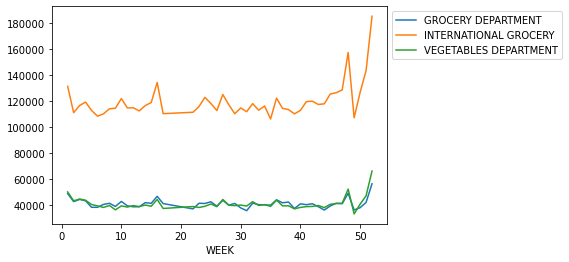

In [100]:
top_subdept_df_2019.groupby(['SUB DPT', 'WEEK'])['Total_Dollars_F65'].sum().unstack('SUB DPT').plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

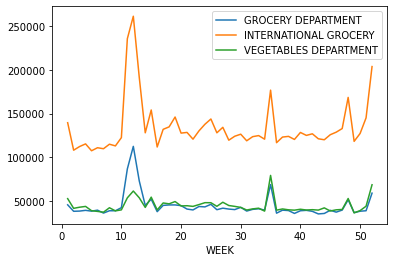

In [101]:
top_subdept_df_2020.groupby(['SUB DPT', 'WEEK'])['Total_Dollars_F65'].sum().unstack('SUB DPT').plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [14]:
high_count_products_df = pd.DataFrame(perez.groupby('DEPT NAME')['DESCRIPTION'].apply(lambda x: x.value_counts().head(5)).reset_index().rename({'level_1':'DESCRIPTION', 'DESCRIPTION':'COUNT'}, axis = 'columns'))
high_count_products_df

,DEPT NAME,DESCRIPTION,COUNT
0,DAIRY DEPT,DAISY SOUR CREAM,327
1,DAIRY DEPT,GOYA FROZEN YUCA,323
2,DAIRY DEPT,LA RICURA CREMA SALVADORENA,317
3,DAIRY DEPT,SUPREMO QUESO FRESCO,314
4,DAIRY DEPT,GOYA PLATANOS MADUROS,307
5,DISCOUNTS,500 Points Get $5.00 OFF,24
6,DISCOUNTS,APPCARD MISCELLANEOUS,15
7,DISCOUNTS,1000 Points Get $10.00 OFF,6
8,DISCOUNTS,2000 Points Get $20.00 OFF,5
9,DISCOUNTS,1500 Points Get $15.00 OFF,2


In [15]:
test = perez.groupby(['DEPT NAME','DESCRIPTION'])['Total_Dollars_F65'].sum().sort_values(ascending=False).reset_index()
top_3_product_revenue = test.groupby('DEPT NAME').head(3)
top_3_product_revenue

,DEPT NAME,DESCRIPTION,Total_Dollars_F65
0,PRODUCE,DRY LOOSE RED BEANS,590818.50
1,PRODUCE,FRESH ROMA TOMATO,583376.48
2,PRODUCE,FRESH HASS AVOCADOS,569791.54
6,GROCERY DEPT,WIC GOOD START GENTLE PDW,391670.66
7,GROCERY DEPT,MASECA CORN FLOUR,386458.83
8,MEAT DEPT,BEEF SKIR STEAK,311354.55
9,MEAT DEPT,COSTILLA GRUESA DE RES,306241.49
11,DAIRY DEPT,KIRKLAND WHOLE MILK,288549.02
13,MEAT DEPT,PORK SHOULDER PICNIC,275697.04
15,GROCERY DEPT,EL MILAGRO CORN TORTILLAS,242283.77


In [26]:
perez.head()

,DATES,UPC_F01,BRAND,DESCRIPTION,TotalUnits_F64,Total_Dollars_F65,SUB DPT #,SUB DPT,DEPT NAME,YEAR,MONTH,WEEK
27126,2019-01-05,2,PHONE CARD,$2 DOLLAR PHONE CARD,28.0,52.36,912,PHONE CARDS,GROCERY DEPT,2019,1,1
27127,2019-01-05,5,PHONE CARD,$5 PHONE CARD,20.0,93.20,912,PHONE CARDS,GROCERY DEPT,2019,1,1
27128,2019-01-05,13,GAS,GAS CILINDER REFILL,14.0,279.86,110,NON FOOD GROCERY,GROCERY DEPT,2019,1,1
27129,2019-01-05,132,AMERIMEX,AMERIMEX $2 REFILL,30.0,60.00,380,AMERIMEX,MISCELLANEOUS DEPT,2019,1,1
27130,2019-01-05,133,**NObrandFOUND**,AMERIMEX $3 REFILL,21.0,63.00,380,AMERIMEX,MISCELLANEOUS DEPT,2019,1,1


In [37]:
subdpt = perez.groupby(['DATES','DEPT NAME', 'SUB DPT'])['TotalUnits_F64', 'Total_Dollars_F65'].sum().reset_index()
subdpt
subdpt.to_csv('subdpt_sales.csv')

C:\Users\joshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [16]:
#remove discounts department - causes NaN problems
top_3_product_revenue = top_3_product_revenue[top_3_product_revenue['DEPT NAME'] != 'DISCOUNTS']

In [17]:
top_product_df = pd.DataFrame(columns=['DATES','DESCRIPTION', 'Total_Dollars_F65'])
for product in top_3_product_revenue['DESCRIPTION'].unique():
    top_product_df = top_product_df.append(perez[['DATES','DESCRIPTION', 'Total_Dollars_F65']].loc[perez['DESCRIPTION'] == product])

In [84]:
red_beans = top_product_df[top_product_df['DESCRIPTION'] == 'DRY LOOSE RED BEANS']

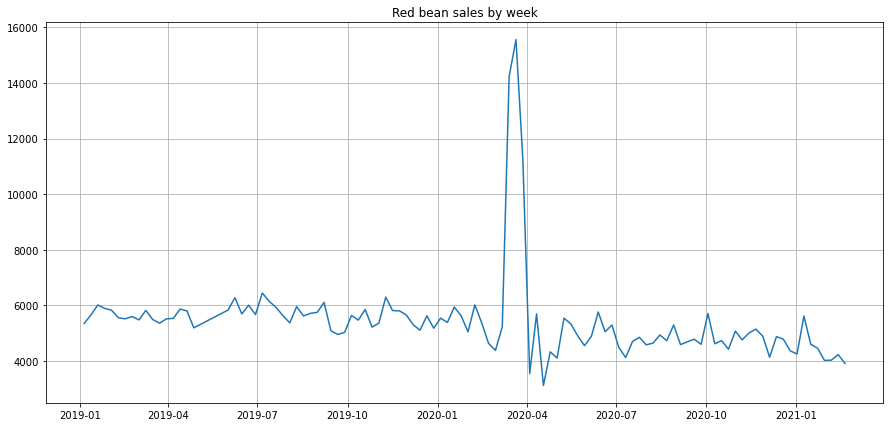

In [85]:
plt.figure(figsize=(15, 7))
plt.plot(red_beans['DATES'], red_beans['Total_Dollars_F65'])
plt.title('Red bean sales by week')
plt.grid(True)
plt.show()


<h3> lets exclude march and see what the top selling products are <h3>

In [19]:
perez_no_march = perez[(perez['DATES'] > '2020-03-31') | (perez['DATES'] < '2020-03-01')]
no_march = perez_no_march.groupby(['DEPT NAME','DESCRIPTION'])['Total_Dollars_F65'].sum().sort_values(ascending=False).reset_index()
top_3_product_revenue_no_march = no_march.groupby('DEPT NAME').head(3)
top_3_product_revenue_no_march

,DEPT NAME,DESCRIPTION,Total_Dollars_F65
0,PRODUCE,FRESH ROMA TOMATO,554648.78
1,PRODUCE,DRY LOOSE RED BEANS,544547.74
2,PRODUCE,FRESH HASS AVOCADOS,538725.44
6,GROCERY DEPT,WIC GOOD START GENTLE PDW,374645.16
7,GROCERY DEPT,MASECA CORN FLOUR,357334.20
8,MEAT DEPT,BEEF SKIR STEAK,295579.97
9,MEAT DEPT,COSTILLA GRUESA DE RES,293729.71
11,DAIRY DEPT,KIRKLAND WHOLE MILK,280779.14
12,MEAT DEPT,PORK SHOULDER PICNIC,267113.94
15,GROCERY DEPT,EL MILAGRO CORN TORTILLAS,232995.26


In [20]:
top_product_df_no_march = pd.DataFrame(columns=['DATES','DESCRIPTION', 'Total_Dollars_F65'])
for product in top_3_product_revenue_no_march['DESCRIPTION'].unique():
    top_product_df_no_march = top_product_df_no_march.append(perez_no_march[['DATES','DESCRIPTION', 'Total_Dollars_F65']].loc[perez_no_march['DESCRIPTION'] == product])

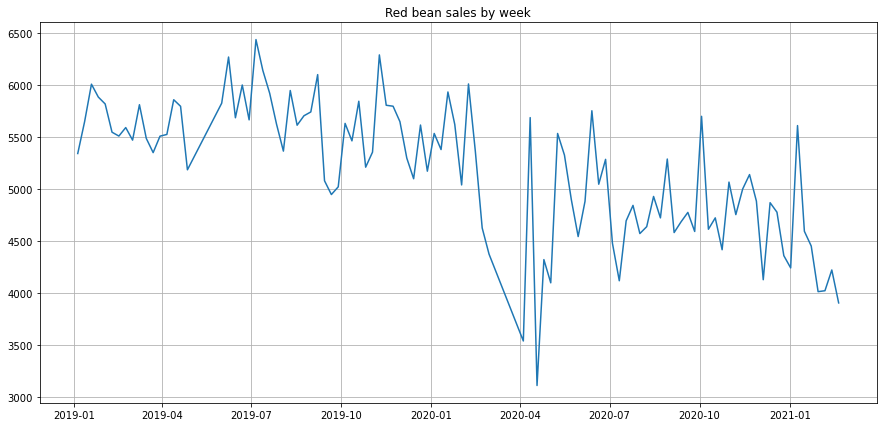

In [105]:
red_beans_no_march = top_product_df_no_march[top_product_df_no_march['DESCRIPTION'] == 'DRY LOOSE RED BEANS']
plt.figure(figsize=(15, 7))
plt.plot(red_beans_no_march['DATES'], red_beans_no_march['Total_Dollars_F65'])
plt.title('Red bean sales by week')
plt.grid(True)
plt.show()


<h3> instead we should create a dummy variable for the month of march 2020 instead of removing it <h3>

In [87]:
#add a 1 for dates in the month of march
top_product_df['COVID'] = np.where((top_product_df['DATES'] < '2020-03-31') & (top_product_df['DATES'] > '2020-03-01'), 1, 0)

In [115]:
def get_timeseries_data(product):
    product_time = top_product_df[top_product_df['DESCRIPTION'] == product]
    product_df = product_time[['DATES', 'Total_Dollars_F65', 'COVID']]
    product_df.columns = ['ds', 'y', 'COVID']
    return product_df

In [116]:
def plot_timeseries(product, weekly, periods):
    data = get_timeseries_data(product)
    m = Prophet(daily_seasonality=False, weekly_seasonality=weekly)
    m.add_regressor('COVID')
    m.fit(data)
    future = m.make_future_dataframe(periods=periods, freq='W')
    future['COVID'] = 0
    forecast=m.predict(future)
    fig1 = m.plot(forecast, xlabel=product)
    return fig1

In [102]:
def forecast_timeseries(product, weekly, periods):
    m = Prophet(daily_seasonality=False, weekly_seasonality=weekly)
    m.add_regressor('COVID')
    m.fit(product)
    future = m.make_future_dataframe(periods=periods, freq='W')
    future['COVID'] = 0
    forecast=m.predict(future)
    return forecast

In [118]:
def plot_performance(product, weekly, periods):
    data = get_timeseries_data(product)
    forecast=forecast_timeseries(data, weekly, periods)

    y_true = data['y'].values
    y_pred = forecast['yhat'][:-periods].values
    
    fig = plt.figure(figsize=(8,6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('Prediction of {}'.format(product))
    plt.legend()
    
    return fig

In [108]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


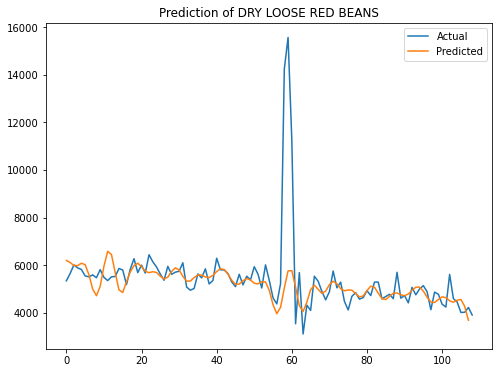

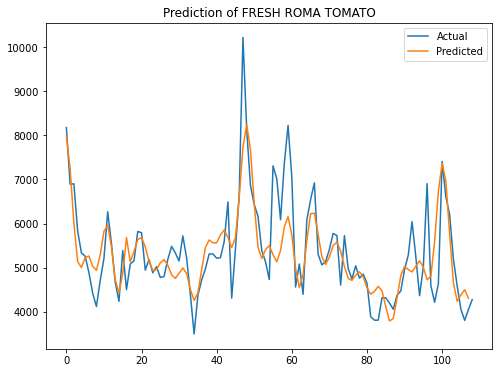

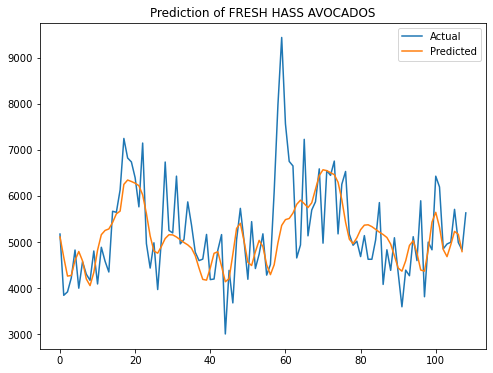

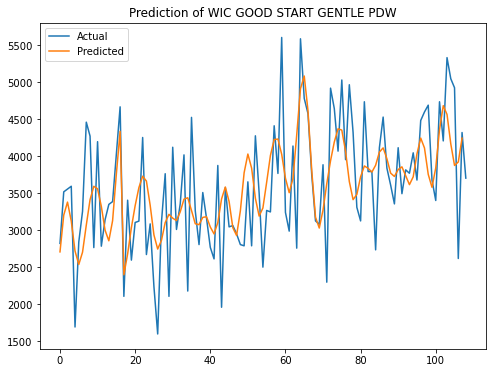

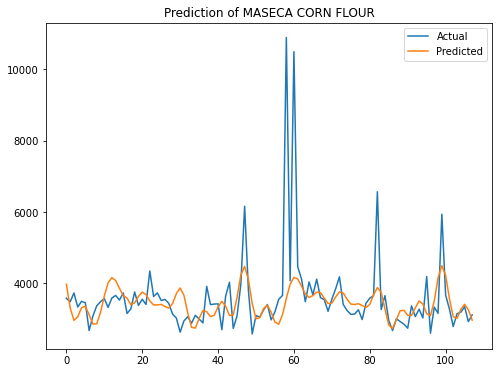

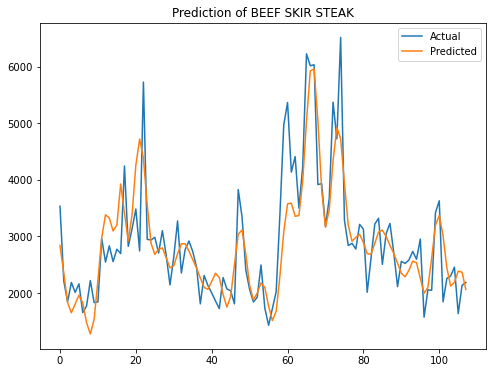

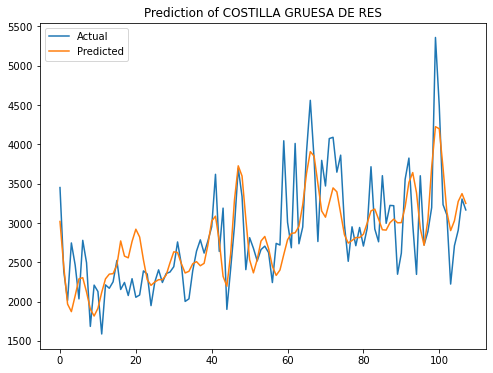

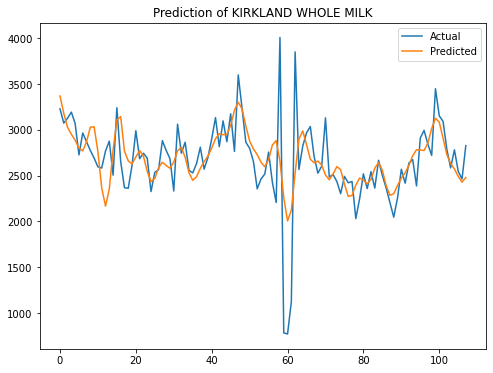

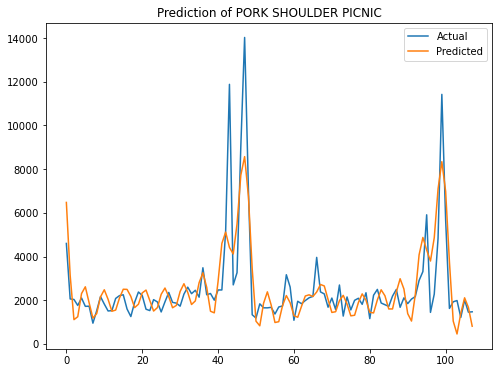

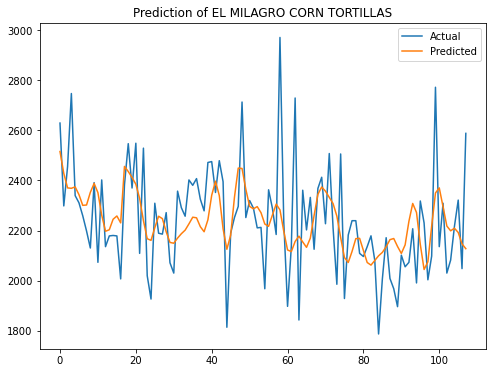

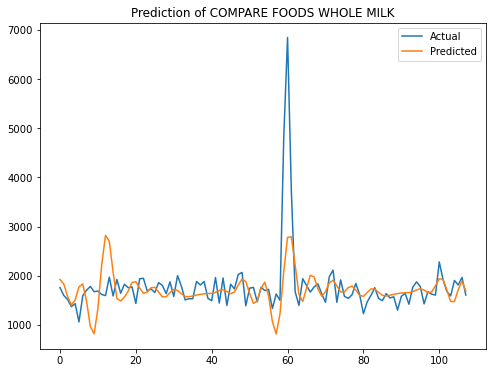

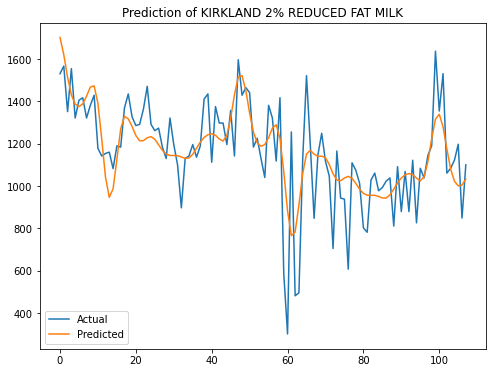

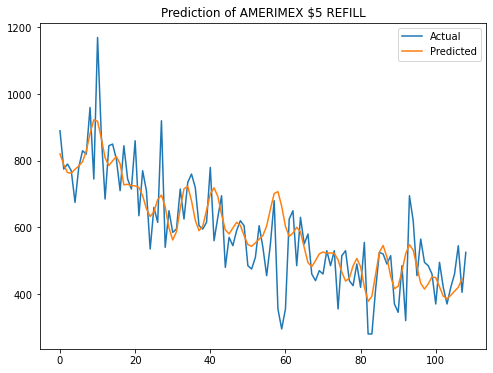

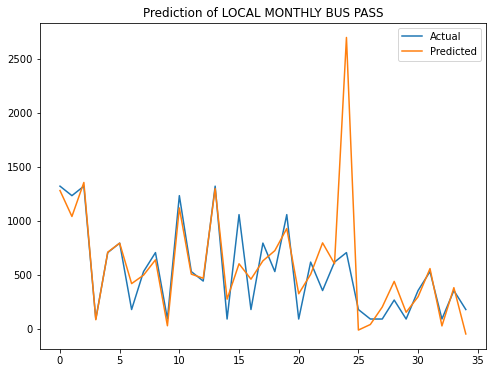

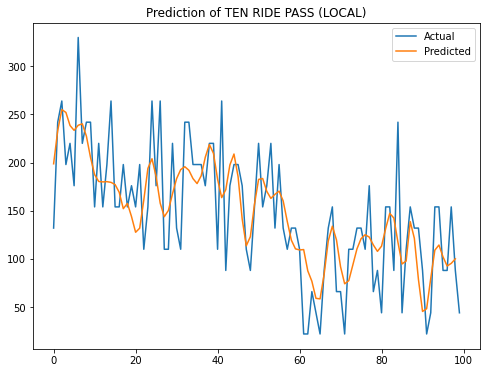

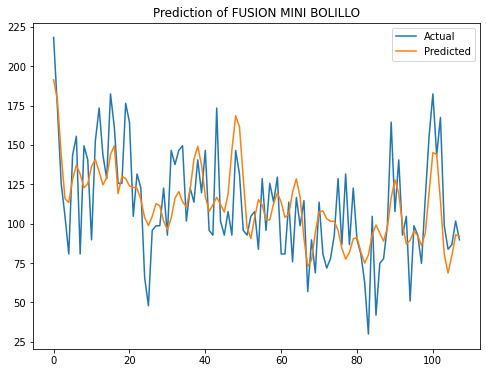

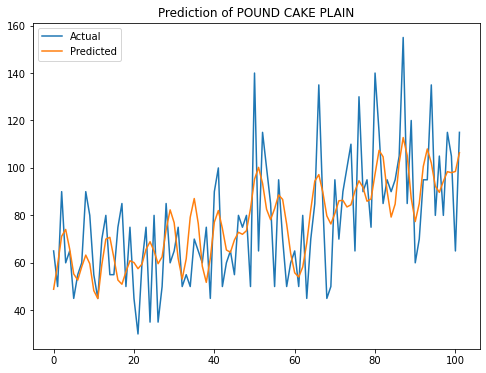

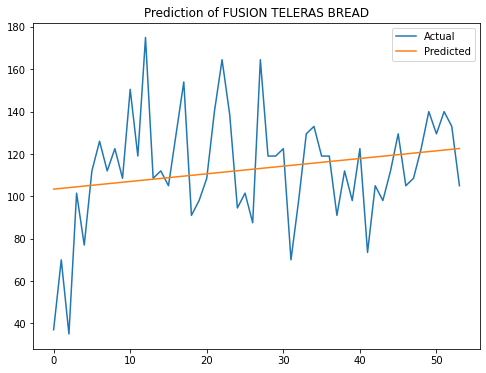

In [120]:
for product in top_product_df['DESCRIPTION'].unique():
    plot = plot_performance(product, False, 26)
    plot

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


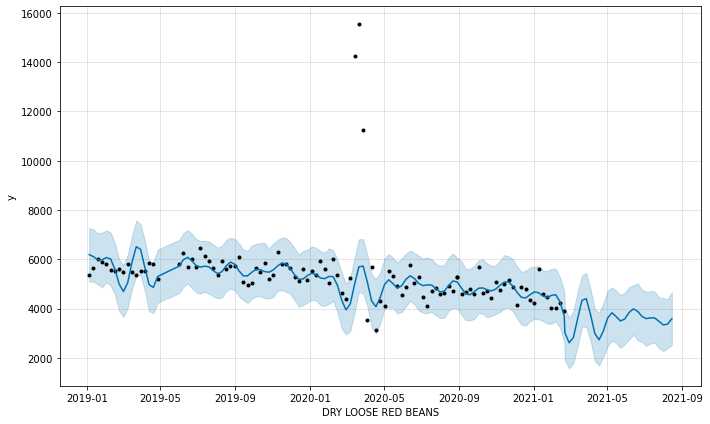

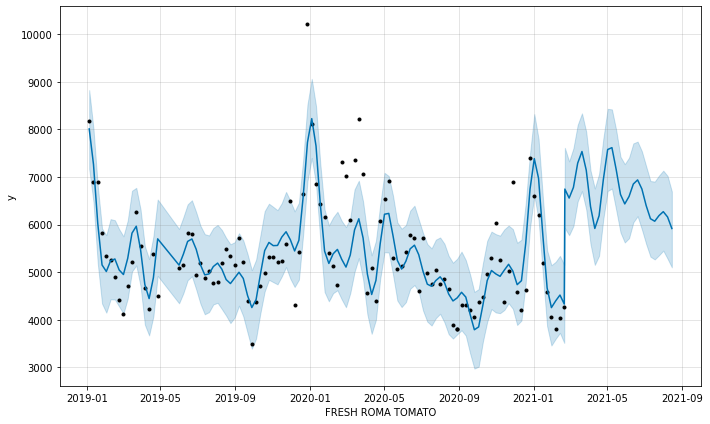

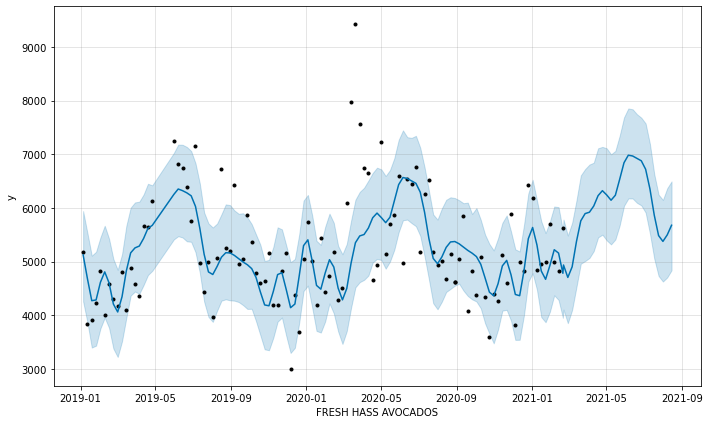

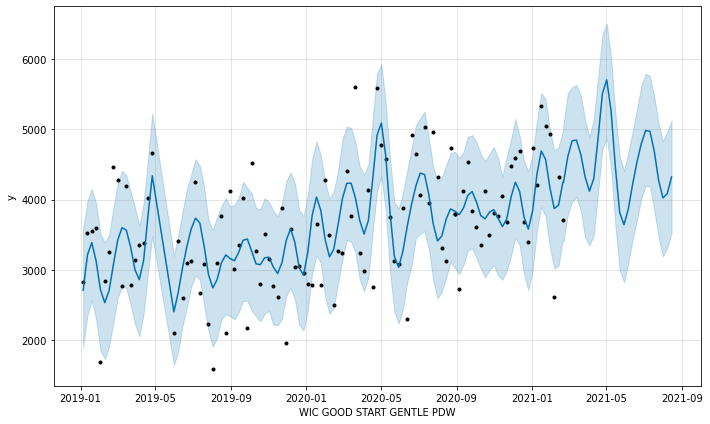

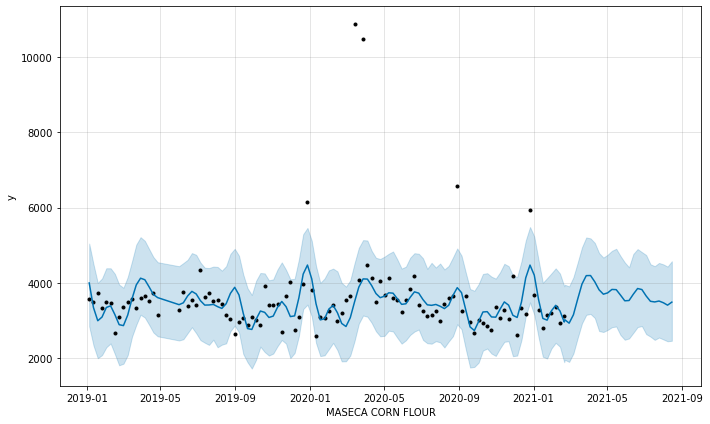

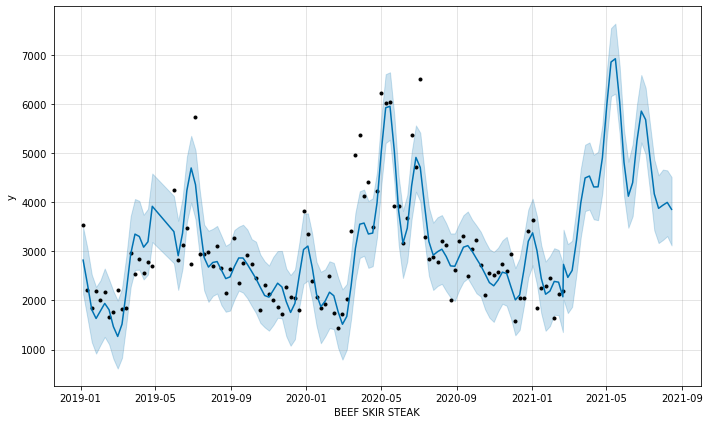

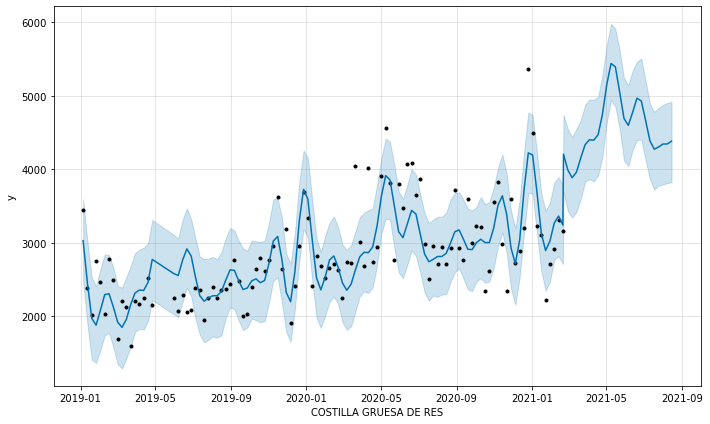

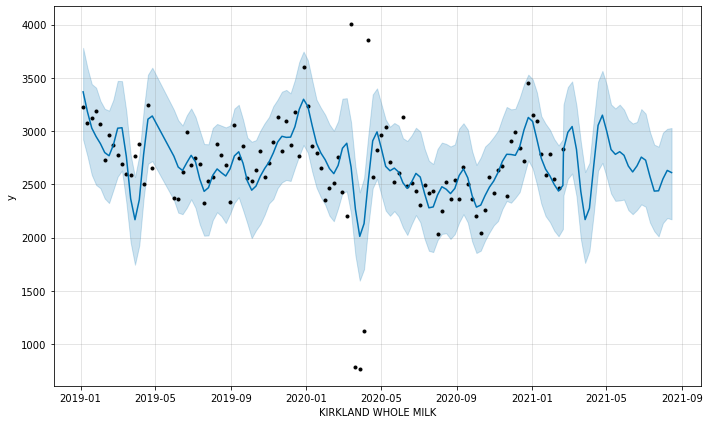

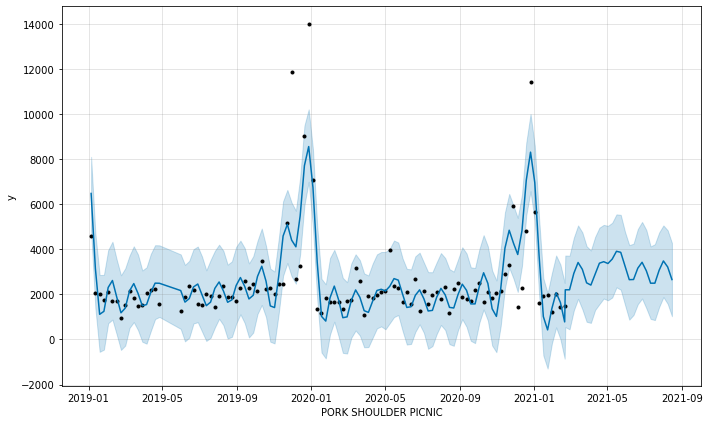

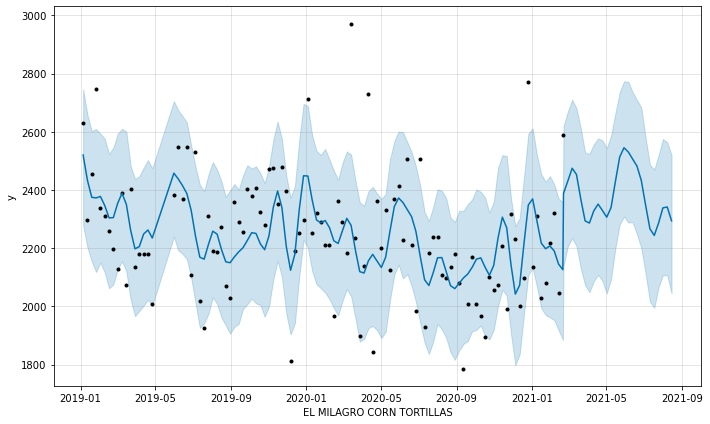

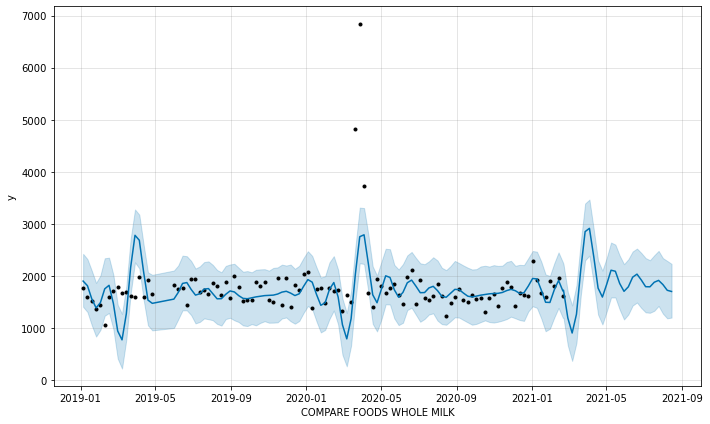

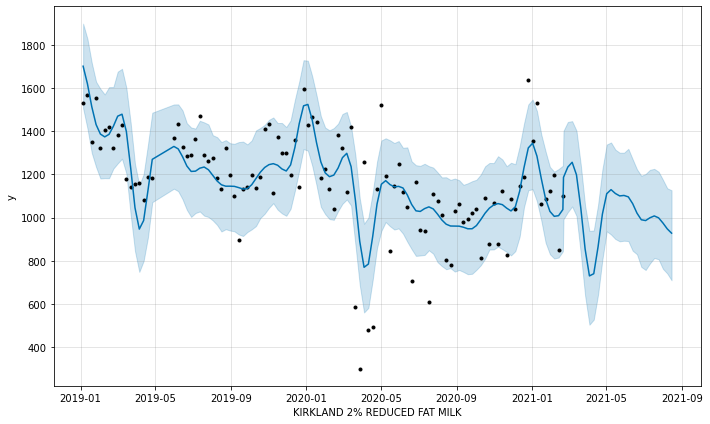

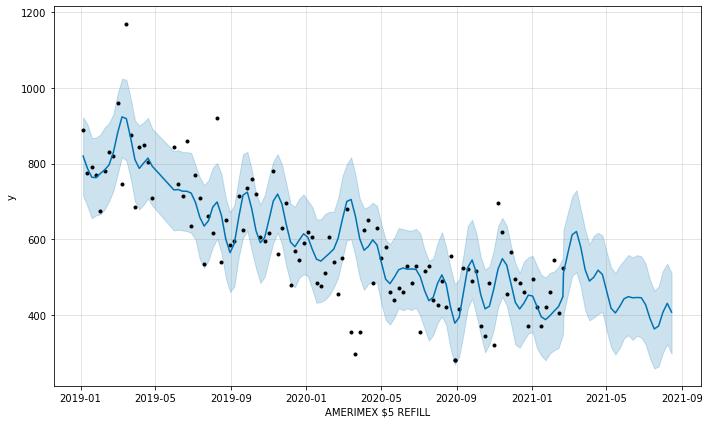

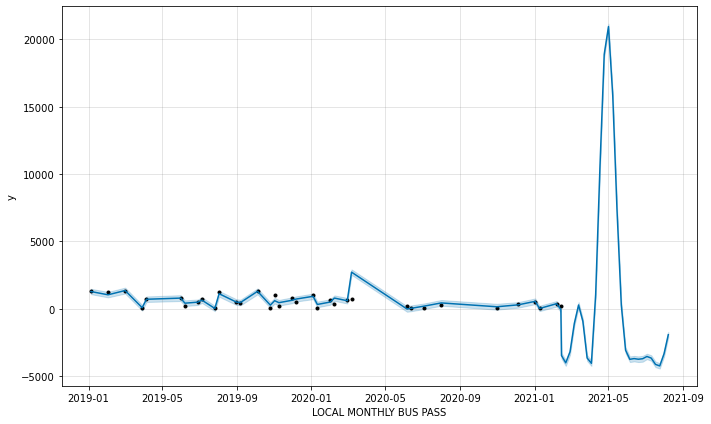

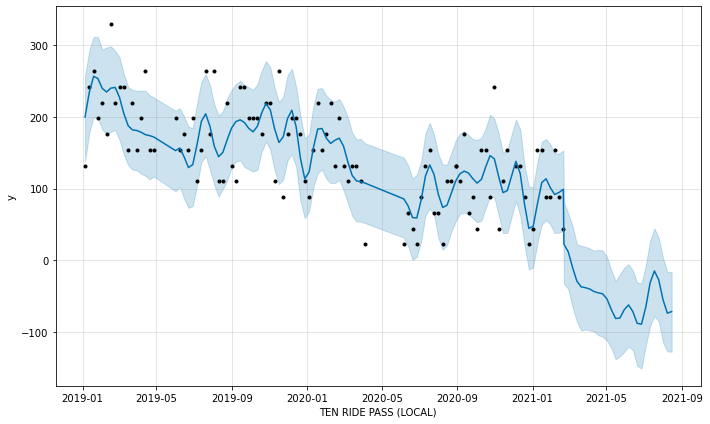

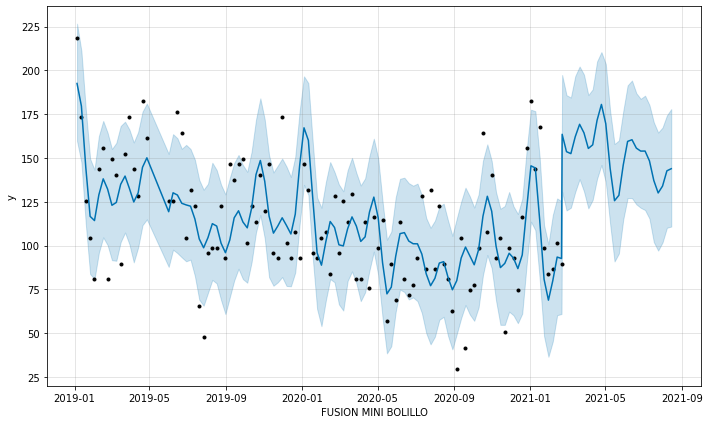

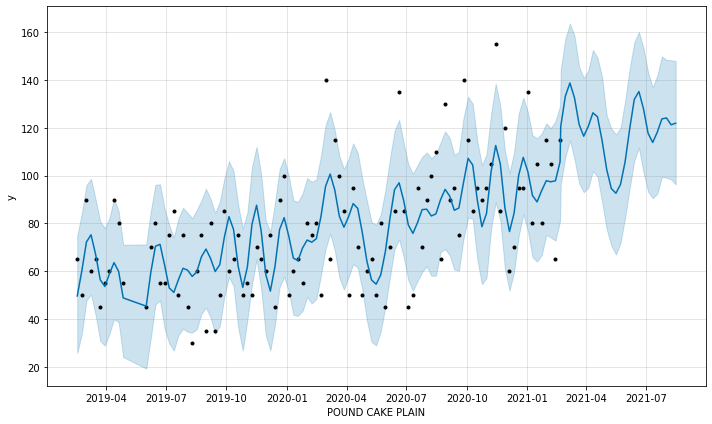

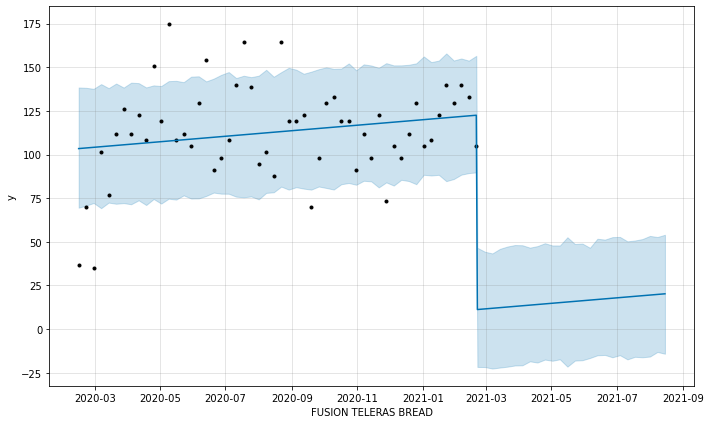

In [121]:
for product in top_product_df['DESCRIPTION'].unique():
    plot_timeseries(product, True, 26)

In [122]:
forecast_df = pd.DataFrame(columns=['DATE', 'Product', 'Predicted_Sales'])
for product in top_product_df['DESCRIPTION'].unique():
    data = get_timeseries_data(product)
    forecast=forecast_timeseries(data, False, 26)
    temp_df = pd.DataFrame({'DATE':forecast['ds'], 'Product':product, 'Predicted_Sales':forecast['yhat']})
    forecast_df = forecast_df.append(temp_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [123]:
forecast_df

,DATE,Product,Predicted_Sales
0,2019-01-05,DRY LOOSE RED BEANS,6199.326418
1,2019-01-12,DRY LOOSE RED BEANS,6113.668553
2,2019-01-19,DRY LOOSE RED BEANS,5986.967220
3,2019-01-26,DRY LOOSE RED BEANS,5985.046556
4,2019-02-02,DRY LOOSE RED BEANS,6081.966783
...,...,...,...
75,2021-07-18,FUSION TELERAS BREAD,130.214050
76,2021-07-25,FUSION TELERAS BREAD,130.575873
77,2021-08-01,FUSION TELERAS BREAD,130.937696
78,2021-08-08,FUSION TELERAS BREAD,131.299520


In [124]:
pivoted_forecast = forecast_df.pivot(index='DATE', columns='Product', values='Predicted_Sales')[-26:]
pivoted_forecast

Product,AMERIMEX $5 REFILL,BEEF SKIR STEAK,COMPARE FOODS WHOLE MILK,COSTILLA GRUESA DE RES,DRY LOOSE RED BEANS,EL MILAGRO CORN TORTILLAS,FRESH HASS AVOCADOS,FRESH ROMA TOMATO,FUSION MINI BOLILLO,FUSION TELERAS BREAD,KIRKLAND 2% REDUCED FAT MILK,KIRKLAND WHOLE MILK,LOCAL MONTHLY BUS PASS,MASECA CORN FLOUR,PORK SHOULDER PICNIC,POUND CAKE PLAIN,TEN RIDE PASS (LOCAL),WIC GOOD START GENTLE PDW
DATE,,,,,,,,,,,,,,,,,,
2021-02-21,450.993499,2011.850311,1625.105650,3218.741201,3603.316189,2129.555307,4735.263241,4264.159509,90.823578,122.615762,1039.162272,2499.019165,-696.293419,2930.276281,726.444338,108.131654,99.906822,4300.049419
2021-02-28,501.949391,1745.053133,1101.817725,2993.976889,3207.919207,2173.089064,4506.569637,4075.817011,81.288428,122.977585,1084.086669,2659.901415,112.454903,2862.694146,727.739252,120.622353,90.234797,4663.913305
2021-03-07,550.585487,1893.127289,831.785783,2871.355027,3450.947693,2218.502958,4705.640645,4303.455909,80.898009,123.339409,1102.203506,2714.838683,2194.141487,3123.573767,1456.072617,126.020224,69.090957,4886.586206
2021-03-14,559.180053,2511.204559,1210.414762,2933.499007,4251.070816,2198.340027,5178.053604,4818.709709,91.151573,123.701232,1041.346618,2500.611078,3548.754005,3573.693152,1940.368597,119.670108,49.383683,4901.251008
2021-03-21,517.145895,3289.511150,2071.838997,3127.228226,4984.103391,2114.001665,5564.254305,5061.555782,98.241632,124.063055,888.137392,2105.518940,2354.522605,3978.815270,1635.600027,108.642582,39.974785,4701.636308
2021-03-28,457.527185,3795.294775,2783.178795,3318.199355,5026.475150,2037.525212,5698.196744,4661.055535,92.686015,124.424878,700.922683,1839.246764,-349.775147,4178.282035,1036.929986,103.921115,38.694180,4380.038482
2021-04-04,426.385242,3824.872753,2822.209289,3403.882021,4351.545734,2028.498227,5722.097043,3887.821719,82.892865,124.786702,580.021722,1943.530820,-735.978429,4140.921414,938.609798,108.345349,39.103715,4174.595735
2021-04-11,436.126984,3592.151859,2259.468132,3411.303543,3559.853619,2068.367556,5834.534352,3422.290097,84.333160,125.148525,592.129486,2344.271753,4325.452151,3942.054856,1429.722255,114.273439,38.570496,4349.663344
2021-04-18,454.647300,3588.862790,1654.342037,3487.137734,3298.427271,2091.180660,6025.516024,3687.240565,98.143087,125.510348,717.026633,2720.960688,13647.701377,3721.708207,1912.644449,112.709744,36.828918,4928.124693


In [125]:
produce = ['DRY LOOSE RED BEANS', 'FRESH HASS AVOCADOS', 'FRESH ROMA TOMATO']
dairy = ['KIRKLAND WHOLE MILK', 'COMPARE FOODS WHOLE MILK', 'KIRKLAND 2% REDUCED FAT MILK']
grocery = ['WIC GOOD START GENTLE PDW', 'MASECA CORN FLOUR', 'EL MILAGRO CORN TORTILLAS']
meat = ['BEEF SKIR STEAK', 'COSTILLA GRUESA DE RES', 'PORK SHOULDER PICNIC']
miscellaneous = ['AMERIMEX $5 REFILL', 'LOCAL MONTHLY BUS PASS', 'TEN RIDE PASS (LOCAL)']
fusion = ['FUSION MINI BOLILLO', 'POUND CAKE PLAIN', 'FUSION TELERAS BREAD']

In [126]:
def plot_predicted(dataframe, department):
    sub_df = dataframe[department]
    plot = sub_df.plot(figsize=(9,5))
            
    return plot

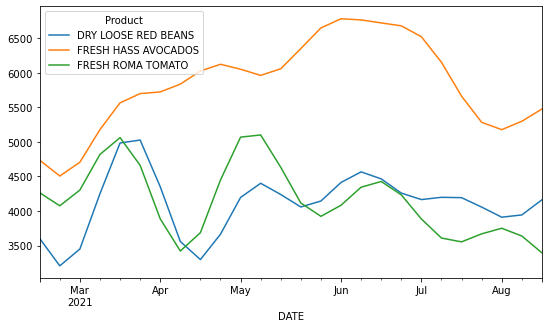

In [127]:
plot_predicted(pivoted_forecast, produce)

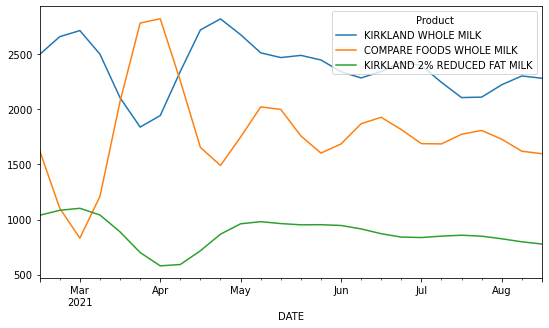

In [128]:
plot_predicted(pivoted_forecast, dairy)

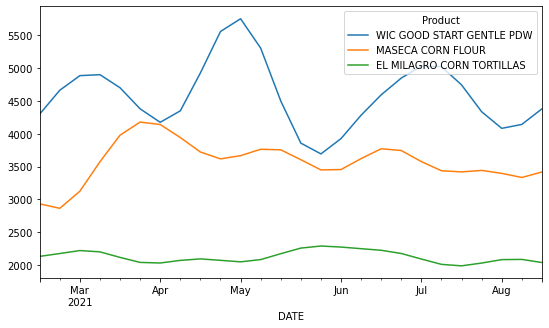

In [129]:
plot_predicted(pivoted_forecast, grocery)

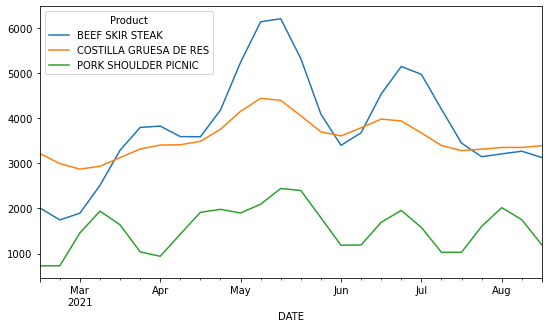

In [130]:
plot_predicted(pivoted_forecast, meat)

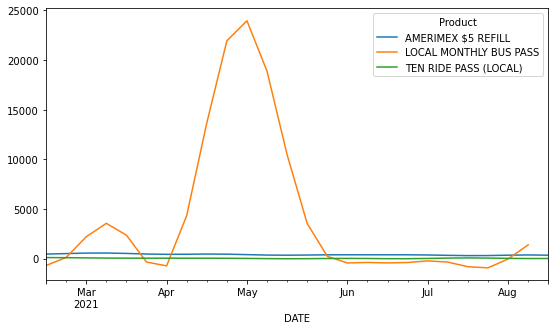

In [131]:
plot_predicted(pivoted_forecast, miscellaneous)

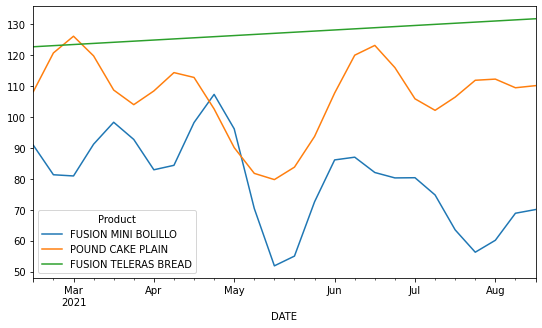

In [132]:
plot_predicted(pivoted_forecast, fusion)

In [100]:
weekly_sales = perez.groupby(['DATES']).sum()['Total_Dollars_F65'].reset_index()
weekly_sales['COVID'] = np.where((weekly_sales['DATES'] < '2020-03-31') & (weekly_sales['DATES'] > '2020-03-01'), 1, 0)
weekly_sales.columns = ['ds', 'y', 'COVID']

In [101]:
weekly_sales

,ds,y,COVID
0,2019-01-05,609618.40,0
1,2019-01-12,503533.14,0
2,2019-01-19,526142.12,0
3,2019-01-26,528468.83,0
4,2019-02-02,510021.17,0
...,...,...,...
103,2021-01-23,532577.64,0
104,2021-01-30,519638.44,0
105,2021-02-06,541106.20,0
106,2021-02-13,532990.54,0


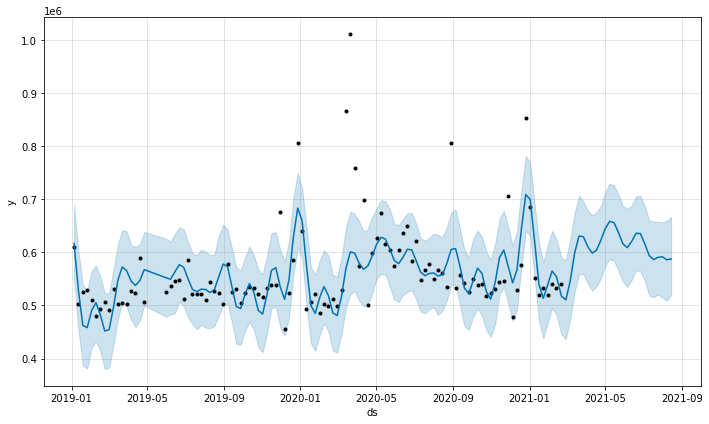

In [103]:
weekly = Prophet(daily_seasonality=False, weekly_seasonality=False)
weekly.add_regressor('COVID')
weekly.fit(weekly_sales)
future = weekly.make_future_dataframe(periods=26, freq='W')
future['COVID'] = 0
forecast=weekly.predict(future)
fig1 = weekly.plot(forecast)

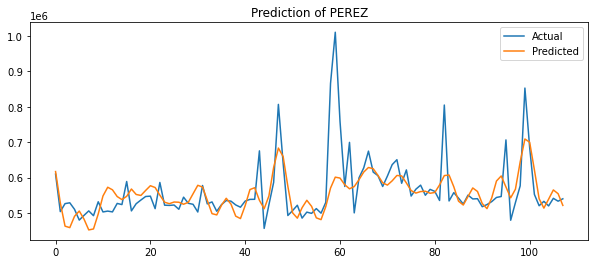

In [107]:
y_true = weekly_sales['y'].values
y_pred = forecast['yhat'][:-26].values

fig = plt.figure(figsize=(10,4))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Prediction of {}'.format('PEREZ'))
plt.legend()

In [109]:
mean_absolute_percentage_error(y_true, y_pred)

6.732833141767223

<h3> Let's look at sales around certain holidays and the super bowl <h3>

In [12]:
def plot_line(df,holiday_dates,holiday_label):
    fig, ax = plt.subplots(figsize = (15,5))  
    ax.plot(df['DATES'],df['Total_Dollars_F65'],label=holiday_label)
    
    for day in holiday_dates:
        day = datetime.datetime.strptime(day, '%Y-%m-%d')
        plt.axvline(x=day, linestyle='--', c='r')
    plt.title(holiday_label)


In [35]:
filt = perez[perez['DATES'] > '2019-09-01']

In [36]:
total_sales = filt.groupby('DATES')['Total_Dollars_F65'].sum().reset_index()
Super_Bowl =['2019-02-03', '2020-02-02']
Labour_Day =  ['2019-09-02', '2020-09-07']
Thanksgiving =  ['2019-11-28', '2020-11-26']
Christmas = ['2019-12-25', '2020-12-25']
Cinco_de_mayo = ['2019-05-05', '2020-05-05']

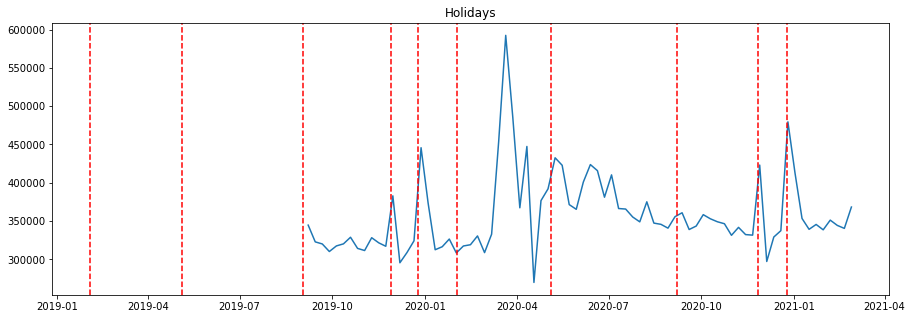

In [37]:
Holidays = ['2019-02-03', '2020-02-02', '2019-09-02', '2020-09-07', '2019-11-28', '2020-11-26', '2019-12-25', '2020-12-25', '2019-05-05', '2020-05-05']
plot_line(total_sales, Holidays, 'Holidays')

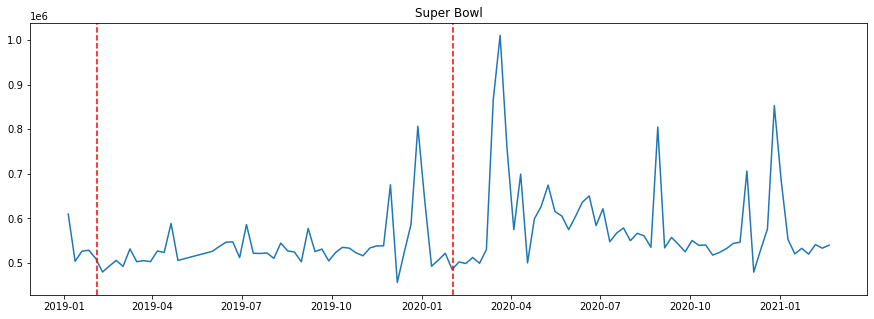

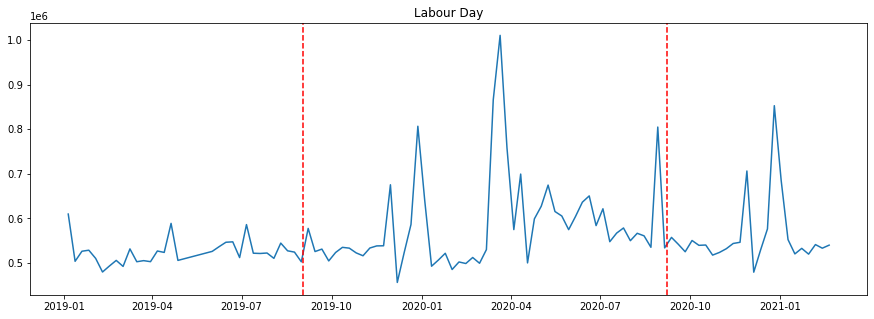

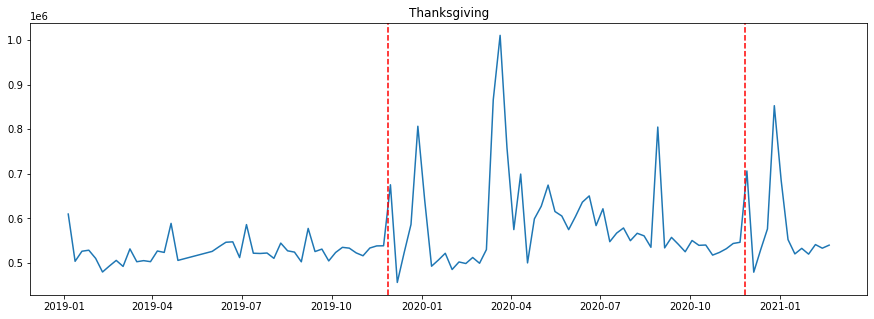

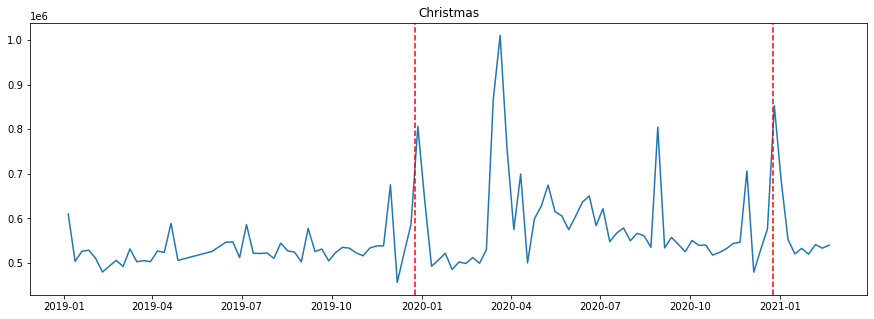

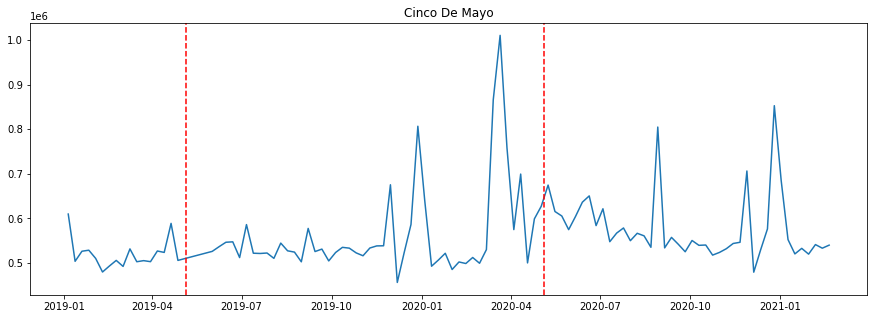

In [33]:
plot_line(total_sales,Super_Bowl,'Super Bowl')
plot_line(total_sales,Labour_Day,'Labour Day')
plot_line(total_sales,Thanksgiving,'Thanksgiving')
plot_line(total_sales,Christmas,'Christmas')
plot_line(total_sales,Cinco_de_mayo,'Cinco De Mayo')

In [35]:
Super_bowl_sat = ['2019-02-02', '2020-02-01']
Labour_day_sat = ['2019-09-07', '2020-09-05']
Thanksgiving_sat = ['2019-11-23', '2020-11-28']
Christman_sat = ['2019-12-28', '2020-12-26']
Cinco_de_mayo_sat = ['2019-04-27', '2020-05-09']

In [73]:
top = perez.groupby(['DEPT NAME','DESCRIPTION'])['Total_Dollars_F65'].sum().sort_values(ascending=False).reset_index()
top_5_product_revenue = top.groupby('DEPT NAME').head(5)
top_5_prods = top_5_product_revenue['DESCRIPTION'].tolist()

In [125]:
average_product_sales = perez.groupby(['DESCRIPTION'])['Total_Dollars_F65'].mean().sort_values(ascending=False).reset_index()
positive_average_product_sales = average_product_sales[average_product_sales['Total_Dollars_F65']>0]

In [158]:
sbs_19 = perez[perez['DATES'] == '2019-02-02']
sbs_19 = sbs_19[['DESCRIPTION', 'Total_Dollars_F65']]

# positive_average_product_sales = positive_average_product_sales.set_index('DESCRIPTION')
sbs_19 = sbs_19.set_index('DESCRIPTION')

sbs_diff = sbs_19.sub(positive_average_product_sales, fill_value=0, axis=0)
sbs_diff.sort_values(by='Total_Dollars_F65',ascending=False)

,Total_Dollars_F65
DESCRIPTION,
FRESH SWEET PAPAYA,1579.305345
FRESH JUICY CELLO ORANGES,921.284694
FRESH SWEET PINEAPPLE,704.999804
LOCAL MONTHLY BUS PASS,696.457143
FRESH SWEET GALA APPLES,539.504852
...,...
FRESH JUICY ORANGES,-1160.372857
SWEET MANGO ATAULFO,-1230.107576
EXTRA LARGE EGGS,-1336.840000


In [170]:
def holiday_diff(date):
    holiday = perez[perez['DATES'] == date]
    holiday = holiday[['DESCRIPTION', 'Total_Dollars_F65']]

    holiday = holiday.set_index('DESCRIPTION')

    diff = holiday.sub(positive_average_product_sales, fill_value=0, axis=0)
    diff.sort_values(by='Total_Dollars_F65',ascending=False)
    
    return diff.head(3)